`Agent #1 Planner Agent`

In [60]:
import json
from typing import Dict, Any, List
from langchain_google_genai import ChatGoogleGenerativeAI

ALLOWED_TASKS = [
    "check_breach_exposure",
    "analyze_github_public_data",
    "check_username_reuse",
    "analyze_bio_exposure"
]


llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

def planner_agent_llm(user_input: Dict[str, Any]) -> Dict[str, Any]:
    """
    LLM-based Planner Agent using Gemini

    - Decides which analysis tasks are relevant
    - Enforces a strict JSON output schema
    - Sanitizes output to prevent hallucinated tasks
    """

    prompt = f"""
You are a planner agent for a cyber risk analysis system.

Your ONLY job:
- Look at the user input
- Decide which analysis tasks apply

STRICT RULES:
- You may ONLY select tasks from the allowed list below
- Do NOT invent new tasks
- Do NOT explain your reasoning
- Do NOT use markdown or code blocks
- Output MUST be valid JSON and nothing else

Allowed tasks:
{ALLOWED_TASKS}

User input:
{json.dumps(user_input, indent=2)}

Return JSON in EXACTLY this format:
{{
  "tasks": [string],
  "notes": [string]
}}
"""

    response = llm.invoke(prompt)

    raw = response.content.strip()

    # Gemini sometimes adds code fences; remove them safely
    if raw.startswith("```"):
        raw = raw.strip("```").strip()

    try:
        parsed = json.loads(raw)
    except json.JSONDecodeError:
        return {
            "normalized_input": user_input,
            "tasks": [],
            "notes": ["Planner LLM returned invalid JSON"]
        }

    raw_tasks = parsed.get("tasks", [])
    notes = parsed.get("notes", [])

    # Enforce whitelist
    tasks: List[str] = [t for t in raw_tasks if t in ALLOWED_TASKS]

    if not tasks:
        notes.append("No valid tasks selected by planner")

    return {
        "normalized_input": user_input,
        "tasks": tasks,
        "notes": notes
    }


`Tools for Agent 2`

In [61]:
import requests

def fetch_github_public_data(username: str) -> dict:
    """
    Fetch basic public GitHub profile data.

    Public, unauthenticated, best-effort.
    Falls back gracefully on failure.
    """

    url = f"https://api.github.com/users/{username}"
    headers = {
        "Accept": "application/vnd.github+json"
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            return {
                "public_repos": None,
                "commit_email_exposed": None,
                "error": f"GitHub API returned {response.status_code}"
            }

        data = response.json()

        return {
            "public_repos": data.get("public_repos"),
            # heuristic placeholder; real check would require repo scan
            "commit_email_exposed": True
        }

    except Exception as e:
        return {
            "public_repos": None,
            "commit_email_exposed": None,
            "error": str(e)
        }

#import requests

def check_email_breach_leakcheck(email: str) -> dict:
    """
    Check email exposure using LeakCheck public API.

    Uses publicly available breach data.
    No API key required.
    Fails gracefully.
    """

    url = f"https://leakcheck.net/api/public?check={email}"

    try:
        response = requests.get(url, timeout=10)

        if response.status_code != 200:
            return {
                "found_in_breaches": None,
                "breach_sources": [],
                "error": f"LeakCheck returned {response.status_code}"
            }

        data = response.json()

        # LeakCheck response format can vary slightly, so be defensive
        found = bool(data.get("found", False))
        sources = []

        if found:
            # Try to extract source names if present
            sources = data.get("sources", [])
            if not isinstance(sources, list):
                sources = []

        return {
            "found_in_breaches": found,
            "breach_sources": sources
        }

    except Exception as e:
        return {
            "found_in_breaches": None,
            "breach_sources": [],
            "error": str(e)
        }

#import requests
PLATFORMS = {
    "GitHub": "https://github.com/{username}",
    "Reddit": "https://www.reddit.com/user/{username}",
    "Dev.to": "https://dev.to/{username}",
    "Medium": "https://medium.com/@{username}",
    "Twitter": "https://twitter.com/{username}"
}


def check_username_reuse(username: str) -> dict:
    """
    Check username reuse across major platforms using existence checks.

    - No auth
    - No scraping
    - Best-effort, fail-safe
    """

    found_platforms = []

    headers = {
        "User-Agent": "DigitalFootprintRiskAgent"
    }

    for platform, url_template in PLATFORMS.items():
        url = url_template.format(username=username)

        try:
            resp = requests.get(url, headers=headers, timeout=8, allow_redirects=True)

            # Heuristic:
            # 200 -> exists
            # 404 -> does not exist
            # 429/403 -> skip quietly
            if resp.status_code == 200:
                found_platforms.append(platform)

        except Exception:
            # Ignore platform failures completely
            continue

    return {
        "value": username,
        "reuse_count": len(found_platforms),
        "platforms": found_platforms
    }




`Agent #2 Information Gathering Agent`

In [62]:
def information_gathering_agent(planner_output: dict) -> dict:
    tasks = planner_output.get("tasks", [])
    inputs = planner_output.get("normalized_input", {})

    evidence = {}

    # ---- Email breach intelligence (LeakCheck – REAL DATA) ----
    if "check_breach_exposure" in tasks and "email" in inputs:
        breach_data = check_email_breach_leakcheck(inputs["email"])

        evidence["email"] = {
            "value": inputs["email"],
            "found_in_breaches": breach_data.get("found_in_breaches"),
            "breach_sources": breach_data.get("breach_sources", [])
        }

    # ---- GitHub public data (already integrated) ----
    if "analyze_github_public_data" in tasks and "username" in inputs:
        username = inputs["username"].rstrip("/").split("/")[-1]
        github_data = fetch_github_public_data(username)

        evidence["github"] = {
            "username": username,
            "public_repos": github_data.get("public_repos"),
            "commit_email_exposed": github_data.get("commit_email_exposed")
        }

        # ---- Username reuse detection (REAL TOOL) ----
    if "check_username_reuse" in tasks and "username" in inputs:
        username_data = check_username_reuse(inputs["username"])

        evidence["username"] = {
            "value": username_data["value"],
            "reuse_count": username_data["reuse_count"],
            "platforms": username_data["platforms"]
        }


    return evidence


`Agent #3 Output Generating Agent`

In [63]:
import json
from typing import Dict, Any, Optional
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

def output_generator_agent(
    evidence: Dict[str, Any],
    feedback: Optional[Dict[str, Any]] = None
) -> Dict[str, Any]:
    """
    Output Generator Agent

    - Generates or revises a structured cyber risk assessment
    - If evaluator feedback is provided, revises the output accordingly
    - Outputs JSON only (no prose)
    """

    revision_instruction = ""
    if feedback is not None:
        revision_instruction = f"""
You have received evaluator feedback indicating issues with the previous output.

Issues identified:
{json.dumps(feedback.get("issues", []), indent=2)}

Suggested changes:
{json.dumps(feedback.get("suggested_changes", {}), indent=2)}

Revise the output to strictly address these issues.
Do NOT introduce new claims.
"""

    prompt = f"""
You are a cyber risk analysis agent.

Your job:
- Analyze the provided evidence
- Compute a cyber risk score between 0 and 100
- Assign a risk level (Low, Medium, High)
- List the main risk factors
- Suggest concrete mitigation steps

{revision_instruction}

STRICT RULES:
- Use ONLY the evidence provided
- Do NOT invent facts
- Do NOT mention tools or APIs
- Do NOT output explanations outside JSON
- Output MUST be valid JSON
- Do NOT use markdown or code blocks

Risk level thresholds:
- 0–30: Low
- 31–60: Medium
- 61–100: High

Evidence:
{json.dumps(evidence, indent=2)}

Return JSON in EXACTLY this format:
{{
  "risk_score": number,
  "risk_level": "Low|Medium|High",
  "risk_factors": [string],
  "mitigations": [string]
}}
"""

    response = llm.invoke(prompt)
    raw = response.content.strip()

    # Gemini sometimes adds code fences
    if raw.startswith("```"):
        raw = raw.strip("```").strip()

    try:
        parsed = json.loads(raw)
    except json.JSONDecodeError:
        return {
            "risk_score": 0,
            "risk_level": "Low",
            "risk_factors": [],
            "mitigations": ["Unable to generate risk assessment due to parsing error"]
        }

    return parsed


`Agent #4 Output Evaluator Agent`

In [64]:
import json
from typing import Dict, Any
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

def evaluator_agent(
    evidence: Dict[str, Any],
    draft_output: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Evaluator Agent (Strict Verification)

    - Verifies that all claims in the draft output are supported by evidence
    - Flags exaggerations or unsupported claims
    - Decides whether the output should be accepted or revised
    - Provides structured feedback for revision if needed
    """

    prompt = f"""
You are a STRICT evaluator agent for a cyber risk analysis system.

Your job:
- Verify that EACH risk factor is clearly supported by the provided evidence
- Identify exaggerations, missing nuance, or unsupported claims
- Decide whether the draft output is acceptable or needs revision

STRICT EVALUATION RULES:
- Be conservative and strict
- Use ONLY the provided evidence
- Do NOT invent new risk factors
- Do NOT introduce new mitigation ideas
- If a claim is even slightly unsupported, flag it
- Do NOT rewrite the output yourself
- Output MUST be valid JSON
- Do NOT use markdown or code blocks
- If multiple independent risk factors are clearly supported by evidence,
you MUST allow a numeric risk_score and corresponding risk_level.

Evidence:
{json.dumps(evidence, indent=2)}

Draft Output:
{json.dumps(draft_output, indent=2)}

Return JSON in EXACTLY this format:
{{
  "verdict": "accept" or "revise",
  "issues": [string],
  "suggested_changes": {{
    "risk_score": number or null,
    "risk_factors": [string] or null,
    "mitigations": [string] or null
  }},
  "summary": string
}}
"""

    response = llm.invoke(prompt)
    raw = response.content.strip()

    # Gemini sometimes adds code fences
    if raw.startswith("```"):
        raw = raw.strip("```").strip()

    try:
        parsed = json.loads(raw)
    except json.JSONDecodeError:
        return {
            "verdict": "accept",
            "issues": ["Evaluator failed to parse output; accepting draft by default"],
            "suggested_changes": {
                "risk_score": None,
                "risk_factors": None,
                "mitigations": None
            },
            "summary": "Evaluation could not be completed reliably"
        }

    return parsed


`State Object`

In [65]:
from typing import TypedDict, Dict, Any, Optional

class AgentState(TypedDict):
    user_input: Dict[str, Any]
    planner_output: Dict[str, Any]
    evidence: Dict[str, Any]

    # Output generation & evaluation
    draft_output: Dict[str, Any]
    evaluation: Optional[Dict[str, Any]]

    # Control fields for revision loop
    revision_count: int

    # Final accepted output
    final_report: Dict[str, Any]


`Node Creation`

In [67]:
MAX_REVISIONS = 2

def planner_node(state: AgentState) -> AgentState:
    state["planner_output"] = planner_agent_llm(state["user_input"])
    state["revision_count"] = 0
    state["evaluation"] = None
    return state


def gather_node(state: AgentState) -> AgentState:
    state["evidence"] = information_gathering_agent(state["planner_output"])
    return state


def generate_node(state: AgentState) -> AgentState:
    """
    Generate or revise draft output.
    If evaluator feedback exists, pass it to the generator.
    """
    feedback = None
    if state.get("evaluation") and state["evaluation"].get("verdict") == "revise":
        feedback = state["evaluation"]

    state["draft_output"] = output_generator_agent(
        state["evidence"],
        feedback=feedback
    )
    return state


def evaluate_node(state: AgentState) -> AgentState:
    """
    Evaluate the draft output.
    Decide accept vs revise.
    Increment revision counter on revise.
    """
    evaluation = evaluator_agent(
        state["evidence"],
        state["draft_output"]
    )

    state["evaluation"] = evaluation

    if evaluation["verdict"] == "accept":
        state["final_report"] = state["draft_output"]
    else:
        state["revision_count"] += 1

        # Force accept if max revisions reached
        if state["revision_count"] >= MAX_REVISIONS:
            state["final_report"] = state["draft_output"]

    return state


`Graph Generation`

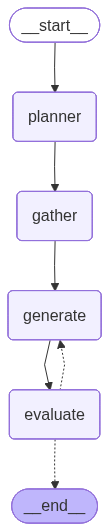

In [68]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

graph = StateGraph(AgentState)

# Nodes
graph.add_node("planner", planner_node)
graph.add_node("gather", gather_node)
graph.add_node("generate", generate_node)
graph.add_node("evaluate", evaluate_node)

# Entry point
graph.set_entry_point("planner")

# Linear flow up to evaluation
graph.add_edge("planner", "gather")
graph.add_edge("gather", "generate")
graph.add_edge("generate", "evaluate")

# Conditional routing after evaluation
def evaluation_router(state: AgentState) -> str:
    if state.get("final_report"):
        return END
    return "generate"

graph.add_conditional_edges(
    "evaluate",
    evaluation_router,
    {
        "generate": "generate",
        END: END
    }
)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))


`Demo Run`

In [69]:
import pprint

initial_state = {
    "user_input": {
        "email": "aryannaithani1085@gmail.com",
        "github": "https://github.com/aryannaithani",
        "username": "aryannaithani",
        "bio": "CS student interested in security"
    },
    "planner_output": {},
    "evidence": {},
    "draft_output": {},
    "evaluation": None,        
    "revision_count": 0,       
    "final_report": {}
}

result = app.invoke(initial_state)

print(result["planner_output"])
print(result["evidence"])
print(result["draft_output"])
print(result["final_report"])
pprint.pprint(result)


{'normalized_input': {'email': 'aryannaithani1085@gmail.com', 'github': 'https://github.com/aryannaithani', 'username': 'aryannaithani', 'bio': 'CS student interested in security'}, 'tasks': ['check_breach_exposure', 'analyze_github_public_data', 'check_username_reuse', 'analyze_bio_exposure'], 'notes': []}
{'email': {'value': 'aryannaithani1085@gmail.com', 'found_in_breaches': True, 'breach_sources': [{'name': 'CutOut.pro', 'date': '2024-02'}]}, 'github': {'username': 'aryannaithani', 'public_repos': 14, 'commit_email_exposed': True}, 'username': {'value': 'aryannaithani', 'reuse_count': 3, 'platforms': ['GitHub', 'Reddit', 'Twitter']}}
{'risk_score': 75, 'risk_level': 'High', 'risk_factors': ['Email address compromised in a data breach (CutOut.pro, 2024-02).', 'Email address publicly exposed through GitHub commits.', "Username 'aryannaithani' reused across multiple online platforms (GitHub, Reddit, Twitter)."], 'mitigations': ['Change the password for the breached email account and a